# Lab Vision Sytems: Session 5

# Today:

### 1: Solution Assignment 4
### 2: Generative Adversarial Networks
### 3: Generating New Clothes

In [1]:
import torch
torch.cuda.is_available()

True

---

# 0. Announcements and Comments

### Transposed Convolutions

Transposed convolutions are the 'inverse' of the convolution operation, and naturally perform upsampling

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**Conv2D** &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**TransposedConv2D**<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Kernel 3x3 &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Kernel 3x3<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Stride == 1  &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;  Stride = 1<br>

<img src="./resources/conv.gif" width=300> <img src="./resources/deconv.gif" width=300>

In [2]:
# upsampling using ConvTranspose
import torch.nn as nn

input = torch.rand(1, 16, 32, 32)

conv_t = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)

output = conv_t(input)
print(f"{output.shape = }")

output.shape = torch.Size([1, 8, 64, 64])


### Problem with Transposed Convolutions

 - https://distill.pub/2016/deconv-checkerboard/


<img src="resources/deconv_only.png" width=80% />

---

---

## Alternatives


### Resize + Convolution


<img src="resources/deconv.png" width=80% />

In [3]:
x = torch.rand(1, 16, 32, 32)

ups_conv = nn.Sequential(
    nn.Upsample(scale_factor=2),
    nn.Conv2d(16, 8, 3, 1, 1)    
)
y = ups_conv(x)
print(f"{x.shape = }")
print(f"{y.shape = }")

x.shape = torch.Size([1, 16, 32, 32])
y.shape = torch.Size([1, 8, 64, 64])


### Pixel Shuffling


$(B, C \times r^2, H, W) \rightarrow (B, C, H \times r, W \times r)$

<img src="resources/pixel_shuffle.pbm" width=40% />

In [4]:
x = torch.rand(1, 16, 32, 32)

ups_conv = nn.Sequential(
    nn.PixelShuffle(upscale_factor=2),
    nn.Conv2d(4, 8, 3, 1, 1)
)
y = ups_conv(x)
print(f"{x.shape = }")
print(f"{y.shape = }")

x.shape = torch.Size([1, 16, 32, 32])
y.shape = torch.Size([1, 8, 64, 64])


# 1: Solution Assignment 5

By Veronika and Vlad

# 2: Generative Adversarial Networks 

# 3: Generating New Clothes

In [5]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

In [6]:
from torch.utils.tensorboard import SummaryWriter

In [7]:
GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "gan")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)

In [8]:
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [9]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if os.path.exists("imgs/training"):
    shutil.rmtree("imgs/training")
if not os.path.exists("imgs/training"):
    os.makedirs("imgs/training")

In [11]:
# Downloading and Loading Dataset
mnist_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
        transforms.Normalize(mean=(0.5, ), std=(0.5, ))
    ])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=mnist_tf, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=mnist_tf)

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) 

In [13]:
imgs = next(iter(train_loader))[0]

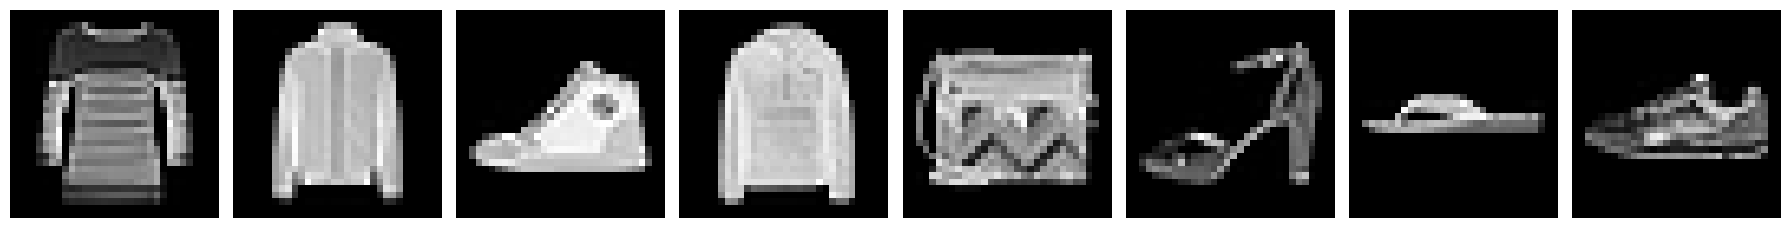

In [15]:
imgs, _ = next(iter(train_loader)) 
fig, ax = plt.subplots(1, 8)
fig.set_size_inches(18, 3)
for i in range(8):
    ax[i].imshow((imgs[i, 0] + 1)/2, cmap="gray")
    ax[i].axis("off")
plt.tight_layout()
plt.show()

## Convolutional GAN

 - Following the DC-GAN Architecture

In [16]:
class ConvBlock(nn.Module):
    """
    Simple convolutional block: Conv + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, add_norm=True, activation="ReLU", dropout=None):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Sigmoid", "Tanh", None]
        padding = kernel_size // 2
        
        block = []
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride))
        if add_norm:
            block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
            
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x):
        """ Forward pass """
        y = self.block(x)
        return y


class ConvTransposeBlock(nn.Module):
    """
    Simple convolutional block: ConvTranspose + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, add_norm=True, activation="ReLU", dropout=None):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Tanh", None]
        padding = kernel_size // 2
        
        block = []
        block.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=stride))
        if add_norm:
            block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x):
        """ Forward pass """
        y = self.block(x)
        return y

In [17]:
class Reshape(nn.Module):
    """ Reshaping a vector in a given shape """
    
    def __init__(self, shape):
        """ """
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        """ """
        B, N = x.shape
        x = x.view(B, N, 1, 1)
        y = x.repeat(1, 1, *self.shape)
        return y

In [18]:
class Generator(nn.Module):
    """
    A fully convolutional generator using ReLU activations. 
    Takes as input a latent vector and outputs a fake sample.
       (B, latent_dim, 1, 1)  --> (B, num_channels, 32, 32)
    """
    def __init__(self, latent_dim=128, num_channels=1, base_channels=32):
        """ Model initializer """
        super().__init__()

        layers = []
        for i in range(4):
            layers.append(
                ConvTransposeBlock(
                        in_channels=latent_dim if i == 0 else base_channels * 2 ** (3-i+1),
                        out_channels=base_channels * 2 ** (3-i),
                        kernel_size=4,
                        stride=1 if i == 0 else 2,
                        add_norm=True,
                        activation="ReLU"
                    )
                )
        layers.append(
            ConvTransposeBlock(
                    in_channels=base_channels,
                    out_channels=num_channels,
                    kernel_size=4,
                    stride=2,
                    add_norm=False,
                    activation="Tanh"
                )
            )
        
        self.model = nn.Sequential(*layers)
        return
    
    def forward(self, x):
        """ Forward pass through generator """
        y = self.model(x)
        return y

In [20]:
generator = Generator(latent_dim=128, num_channels=1, base_channels=32)
print(generator)
gen_img = generator(torch.rand(1, 128, 1, 1))

Generator(
  (model): Sequential(
    (0): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  

In [22]:
class Discriminator(nn.Module):
    """ A fully convolutional discriminator using LeakyReLU activations. 
    Takes as input either a real or fake sample and predicts its autenticity.
       (B, num_channels, 32, 32)  -->  (B, 1, 1, 1)
    """
    def __init__(self, in_channels=1, out_dim=1, base_channels=32, dropout=0.3):
        """ Module initializer """
        super().__init__()  
        
        layers = []
        for i in range(4):
            layers.append(
                ConvBlock(
                        in_channels=in_channels if i == 0 else base_channels * 2 ** i,
                        out_channels=base_channels * 2 ** (i + 1),
                        kernel_size=4,
                        add_norm=True,
                        activation="LeakyReLU",
                        dropout=dropout,
                        stride=2
                    )
                )
        layers.append(
                ConvBlock(
                        in_channels=base_channels * 16,
                        out_channels=out_dim,
                        kernel_size=4,
                        stride=4,
                        add_norm=False,
                        activation="Sigmoid"
                    )
                )
        
        self.model = nn.Sequential(*layers)
        return
      
    def forward(self, x):
        """ Forward pass """
        y = self.model(x)
        return y

In [23]:
discriminator = Discriminator(in_channels=1, out_dim=1, base_channels=32)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
 

In [24]:
generator = Generator(latent_dim=128, num_channels=1, base_channels=32)
discriminator = Discriminator(in_channels=1, out_dim=1, base_channels=32)

In [25]:
latent = torch.randn(16, 128, 1, 1)
fake_img = generator(latent)
score = discriminator(fake_img)
print(f"{fake_img.shape = }")
print(f"{score.shape = }")

fake_img.shape = torch.Size([16, 1, 32, 32])
score.shape = torch.Size([16, 1, 1, 1])


## Training Code

In [26]:
# utils
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(loss_iters, train_loss, val_loss):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("log")
    ax[0].set_title("Training Progress")

    smooth_loss = smooth(loss_iters, 31)
    START = 500
    N_ITERS = len(loss_iters)
    ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title(f"Training Progress from Iter {START}")

    epochs = np.arange(len(train_loss)) + 1
    ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
    ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_title("Loss Curves")


In [28]:
class Trainer:
    """
    Class for initializing GAN and training it
    """
    def __init__(self, generator, discriminator, latent_dim=128, writer=None):
        """ Initialzer """
        assert writer is not None, f"Tensorboard writer not set..."
    
        self.latent_dim = latent_dim
        self.writer = writer 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        
        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=3e-4, betas=(0.5, 0.9))
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=3e-4, betas=(0.5, 0.9))
        
        # REAL LABEL = 1
        # FAKE LABEL = 0
        # eps = 1e-10
        # self.criterion_d_real = lambda pred: torch.clip(-torch.log(1 - pred + eps), min=-10).mean()
        # self.criterion_d_fake = lambda pred: torch.clip(-torch.log(pred + eps), min=-10).mean()
        # self.criterion_g = lambda pred: torch.clip(-torch.log(1 - pred + eps), min=-10).mean()
        
        self.criterion_g = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_real = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_fake = lambda pred: F.binary_cross_entropy(pred, torch.zeros(pred.shape[0], device=pred.device))
        
        
        self.hist = {
            "d_real": [],
            "d_fake": [],
            "g": []
        }
        return
        
    def train_one_step(self, imgs):
        """ 
        Training both models for one optimization step
        """
        self.generator.train()
        self.discriminator.train()
        
        # Sample from the latent distribution
        B = imgs.shape[0]
        latent = torch.randn(B, self.latent_dim, 1, 1).to(self.device)
        
        # ==== Training Discriminator ====
        self.optim_discriminator.zero_grad()
        # Get discriminator outputs for the real samples
        prediction_real = self.discriminator(imgs)
        # Compute the loss function
        d_loss_real = self.criterion_d_real(prediction_real.view(B))

        # Generating fake samples with the generator
        fake_samples = self.generator(latent)
        # Get discriminator outputs for the fake samples
        prediction_fake_d = self.discriminator(fake_samples.detach())  # why detach?
        # Compute the loss function
        d_loss_fake = self.criterion_d_fake(prediction_fake_d.view(B))
        (d_loss_real + d_loss_fake).backward()
        assert fake_samples.shape == imgs.shape
        
        # optimization step
        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        self.optim_discriminator.step()
        
        # === Train the generator ===
        self.optim_generator.zero_grad()
        # Get discriminator outputs for the fake samples
        prediction_fake_g = self.discriminator(fake_samples)
        # Compute the loss function
        g_loss = self.criterion_g(prediction_fake_g.view(B))
        g_loss.backward()
        # optimization step
        self.optim_generator.step()
        
        return d_loss_real, d_loss_fake, g_loss
    
    @torch.no_grad()
    def generate(self, N=64):
        """ Generating a bunch of images using current state of generator """
        self.generator.eval()
        latent = torch.randn(N, self.latent_dim, 1, 1).to(self.device)
        imgs = self.generator(latent)
        imgs = imgs * 0.5 + 0.5
        return imgs
        
    def train(self, data_loader, N_iters=10000, init_step=0):
        """ Training the models for several iterations """
        
        progress_bar = tqdm(total=N_iters, initial=init_step)
        running_d_loss = 0
        running_g_loss = 0
        
        iter_ = 0
        for i in range(N_iters):
            for real_batch, _ in data_loader:           
                real_batch = real_batch.to(self.device)
                d_loss_real, d_loss_fake, g_loss = self.train_one_step(imgs=real_batch)
                d_loss = d_loss_real + d_loss_fake
            
                # updating progress bar
                progress_bar.set_description(f"Ep {i+1} Iter {iter_}: D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                
                # adding stuff to tensorboard
                self.writer.add_scalar(f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
                self.writer.add_scalar(f'Loss/Discriminator Loss', d_loss.item(), global_step=iter_)
                self.writer.add_scalars(f'Loss/Discriminator Losses', {
                        "Real Images Loss": d_loss_real.item(),
                        "Fake Images Loss": d_loss_fake.item(),
                    }, global_step=iter_)
                self.writer.add_scalars(f'Comb_Loss/Losses', {
                            'Discriminator': d_loss.item(),
                            'Generator':  g_loss.item()
                        }, iter_)    
                if(iter_ % 200 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    self.writer.add_image('images', grid, global_step=iter_)
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "imgs", "training", f"imgs_{iter_}.png"))

                iter_ = iter_ + 1 
                
        return

In [29]:
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [30]:
generator = Generator(latent_dim=128, num_channels=1, base_channels=32)
discriminator = Discriminator(in_channels=1, out_dim=1, base_channels=32)

trainer = Trainer(generator=generator, discriminator=discriminator, latent_dim=128, writer=writer)

In [31]:
trainer.train(data_loader=train_loader)

Ep 5 Iter 4322: D_Loss=0.30974, G_Loss=1.27143):   0%|                                                                                                                                                             | 0/10000 [04:56<?, ?it/s]

KeyboardInterrupt: 

### Making gif

In [32]:
import imageio

images = []
img_path = os.path.join(os.getcwd(), "imgs", "training")

# making list with images and orting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(x.split("_")[1].split(".")[0]))

In [33]:
for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))
imageio.mimsave(os.path.join(img_path, "progress.gif"), images)

### Generating some Images

In [39]:
imgs = trainer.generate()
grid = torchvision.utils.make_grid(imgs, nrow=8)

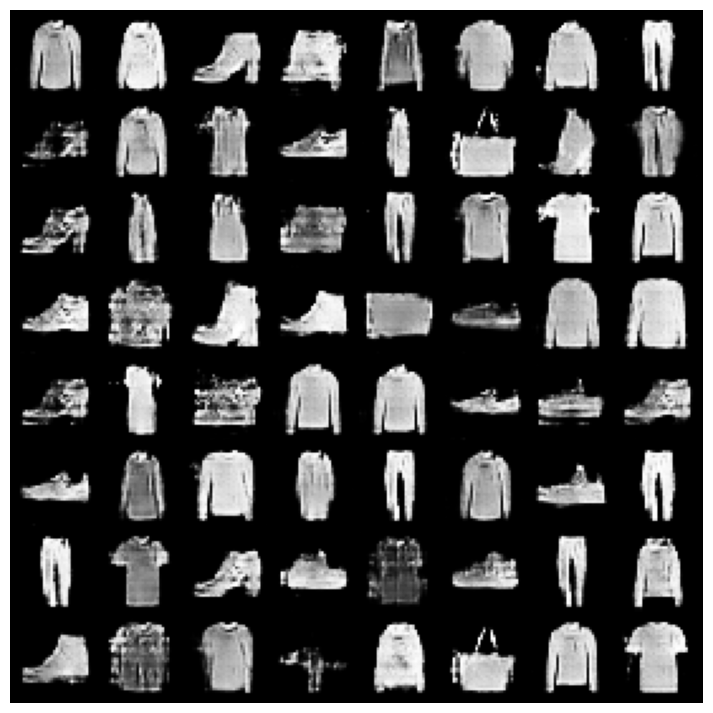

In [40]:
plt.figure(figsize=(9,9))
plt.imshow(grid[0].cpu(), cmap="gray")
plt.axis("off")
plt.show()

# Assignment 5
 - Task 1:
    - Implement a fully convolutional DCGAN-like model (https://arxiv.org/abs/1511.06434)
    - Train the model on the AFHQ (Animal Faces-HQ) dataset from Assignment 5 in order to generate new animal faces
    - Requirements:
      - Use Tensorboard, WandDB or some other experiment tracker
      - Show the capabilities of your model to generate images
      - Evaluate and track during training using one quantitative metric (e.g. FID)
      - Compare your GAN with your best VAE from Assignment 4.
          - Which model has best FID scores?
          - Which model generates more realistic images?
          - What are the strengths and weaknesses of each model?
 

  - Task 2:
      - Implement a **Conditional DCGAN** model (https://arxiv.org/abs/1411.1784)
       - Train the model for conditional generation on the AFHQ dataset
       - Requirements:
         - Use Tensorboard, WandDB or some other experiment tracker
         - Show the capabilities of the model to generate data based on given label
 
 
 
 - Extra point:
    - Train a SAGAN (self-attention GAN, (https://arxiv.org/abs/1805.08318)) or BigGAN (https://arxiv.org/abs/1809.11096) model on the AFHQ dataset
    - You are allowed to use open-source implementations
    - Compare, both qualitatively and quantitatively, SAGAN/BigGAN with the DCGAN from task 1
    

#### **Due Date**: Monday 16th June at 23:59
#### Submit it by mail using the subject: **CudaLab: Assignment5 + Group Number**
####  Send me the following: Jupyter Notebook after running, Jupyter export as **html**, **Tensorboard Logs**, any other .py files or images used.

# References
 - https://www.deeplearningbook.org/
 - https://towardsdatascience.com/all-you-want-to-know-about-deep-learning-8d68dcffc258
 - https://github.com/soumith/ganhacks
 - https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div>  